# piNNs benchmark for continnuum mechanics application

In this work we adress the boundary value problem introduced in [1] that has an analytical solution (considering linear elasticity).

We consider the unit square domain : $\Omega = [0,1]^2$, on whiwh the continnum mechanics equations applies :

$ \epsilon_{ij} = \frac{1}{2}(u_{i,j}+u_{j,i}) $\
$ \sigma_{ij} =  \lambda \epsilon_{ij} \delta{ij} + 2 \mu \epsilon_{ij}$\
$ \sigma_{ij,j} + f_{i} = 0 $

The boundary condition are summarized in the image bellow [1], and the body forces are choosen on purpose so that there can be an analytical solution :

$fx = \lambda \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 4 \pi^{2} \sin{\left(2 \pi y \right)} \cos{\left(2 \pi x \right)}\right) + \mu \left(- \pi Q y^{3} \cos{\left(\pi x \right)} + 9 \pi^{2} \sin{\left(\pi y \right)}\right)$\
$fy = \lambda \left(- 3 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right) + \mu \left(\frac{\pi^{2} Q y^{4} \sin{\left(\pi x \right)}}{16} - 6 Q y^{2} \sin{\left(\pi x \right)} + 2 \pi^{2} \sin{\left(2 \pi x \right)} \cos{\left(\pi y \right)}\right)$


[1] Haghighat, Ehsan, Maziar Raissi, Adrian Moure, Hector Gomez, and Ruben Juanes. “A Deep Learning Framework for Solution and Discovery in Solid Mechanics.” 

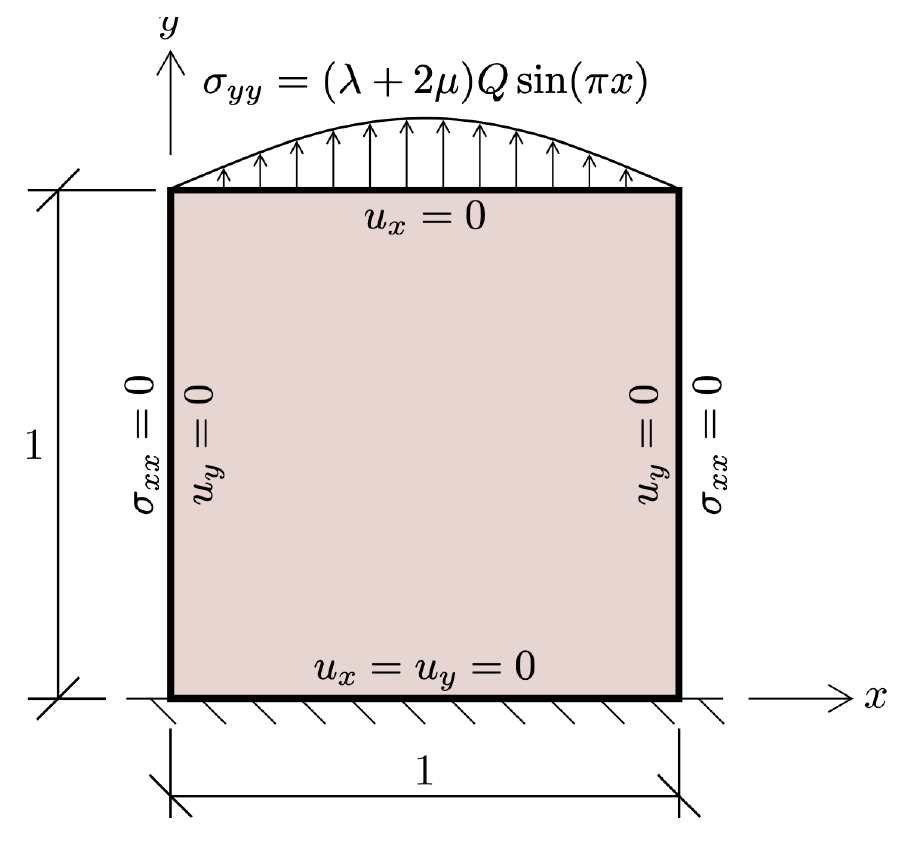

In [126]:
from IPython.display import Image
Image(filename='SciANN_example.png', width=500)

### Analytical solution resolution using symbolic math (sympy)

In [31]:
## Analytical solution
from sympy import *

# define symbols
x, y, Q_, lambda_, mu_ = symbols('x y Q lambda mu')

# define body force
fx = lambda_*(4*pi**2*cos(2*pi*x)*sin(pi*y)-pi*cos(pi*x)*Q_*y**3) \
    + mu_*(9*pi**2*cos(2*pi*x)*sin(pi*y) - pi*cos(pi*x)*Q_*y**3)

fy = lambda_*(-3*sin(pi*x)*Q_*y**2 + 2*pi**2*sin(2*pi*x)*cos(pi*y)) \
    + mu_*(-6*sin(pi*x)*Q_*y**2 + 2*pi**2*sin(2*pi*x)*cos(pi*y) + (pi**2*sin(pi*x)*Q_*y**4)/4)

# define displacement (known analytical solution)
Ux = cos(2*pi*x)*sin(pi*y)
Uy = sin(pi*x)*Q_*y**4/4 
#--> the boundary are directly satisfied

# compute strain and stress
Exx = diff(Ux,x)
Eyy = diff(Uy,y)
Exy = 1/2*(diff(Uy,x) + diff(Ux,y))

Sxx = (lambda_ + 2*mu_) * Exx + lambda_ * Eyy
Syy = (lambda_ + 2*mu_) * Eyy + lambda_ * Exx
Sxy = 2*mu_*Exy

# compute momentum balance and check if it is zero
Mx = diff(Sxx,x) + diff(Sxy,y) + fx
My = diff(Sxy,x) + diff(Syy,y) + fy

print(f"Momentum balance : (Mx, My) = ({simplify(Mx)}, {simplify(My)})")

# compute potential energy
E_strain = 1/2 * (Exx*Sxx + Eyy*Syy + 2*Exy*Sxy)
W_bodyf = Ux*fx + Uy*fy
E_potential = E_strain - W_bodyf
E_potential_tot = integrate(E_potential, (x, 0, 1), (y, 0, 1)).evalf(subs={Q_: 4, lambda_: 1, mu_: 0.5})

print(f"Potential energy (integrated) = {E_potential_tot}")

Momentum balance : (Mx, My) = (0, 0)
Potential energy (integrated) = -7.76638965791861


In [144]:
#define functions for the analytical solution (ground truth = gt)
import numpy as np

lmbd = 1.0
mu = 0.5
Q = 4.0

def U_gt(x,y):
    #displacement U
    Ux = np.cos(2*torch.pi*x) * np.sin(np.pi*y)
    Uy = np.sin(np.pi*x) * Q * y**4/4
    return (Ux, Uy)

def E_gt(x,y):
    #strain E
    Exx = -2*np.pi*np.sin(2*np.pi*x)*np.sin(np.pi*y)
    Eyy = np.sin(np.pi*x)*Q*y**3
    Exy = 0.5*(np.pi*np.cos(2*np.pi*x)*np.cos(np.pi*y) + np.pi*np.cos(np.pi*x)*Q*y**4/4)
    return (Exx, Eyy, Exy)

def S_gt(x,y):
    #stress S
    Sxx = (lmbd + 2*mu) * E_gt(x,y)[0] + lmbd * E_gt(x,y)[1]
    Syy = (lmbd + 2*mu) * E_gt(x,y)[1] + lmbd * E_gt(x,y)[0]
    Sxy = 2*mu*E_gt(x,y)[2]
    return (Sxx, Syy, Sxy)

def bodyf_gt(x,y):
    #body force
    fx = lmbd*(4*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y)-np.pi*np.cos(np.pi*x)*Q*y**3) \
        + mu*(9*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y) - np.pi*np.cos(np.pi*x)*Q*y**3)
    fy = lmbd*(-3*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y)) \
        + mu*(-6*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y) + (np.pi**2*np.sin(np.pi*x)*Q*y**4)/4)
    return (fx, fy)
    
def E_potential_gt(x,y):
    #potential energy
    E_strain = 1/2 * (E_gt(x,y)[0]*S_gt(x,y)[0] + E_gt(x,y)[1]*S_gt(x,y)[1] + 2*E_gt(x,y)[2]*S_gt(x,y)[2])
    W_bodyf = U_gt(x,y)[0]*bodyf_gt(x,y)[0] + U_gt(x,y)[1]*bodyf_gt(x,y)[1]
    E_potential = E_strain - W_bodyf
    return [E_potential]

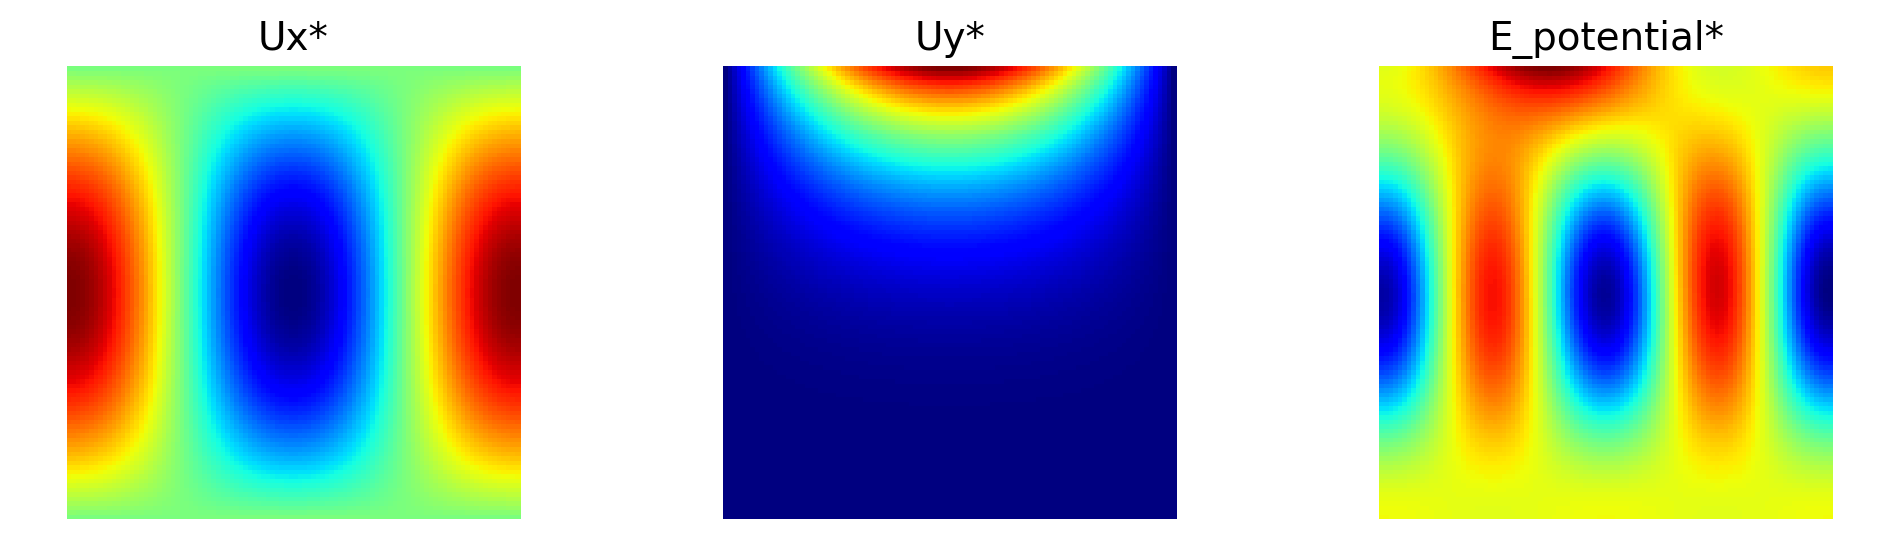

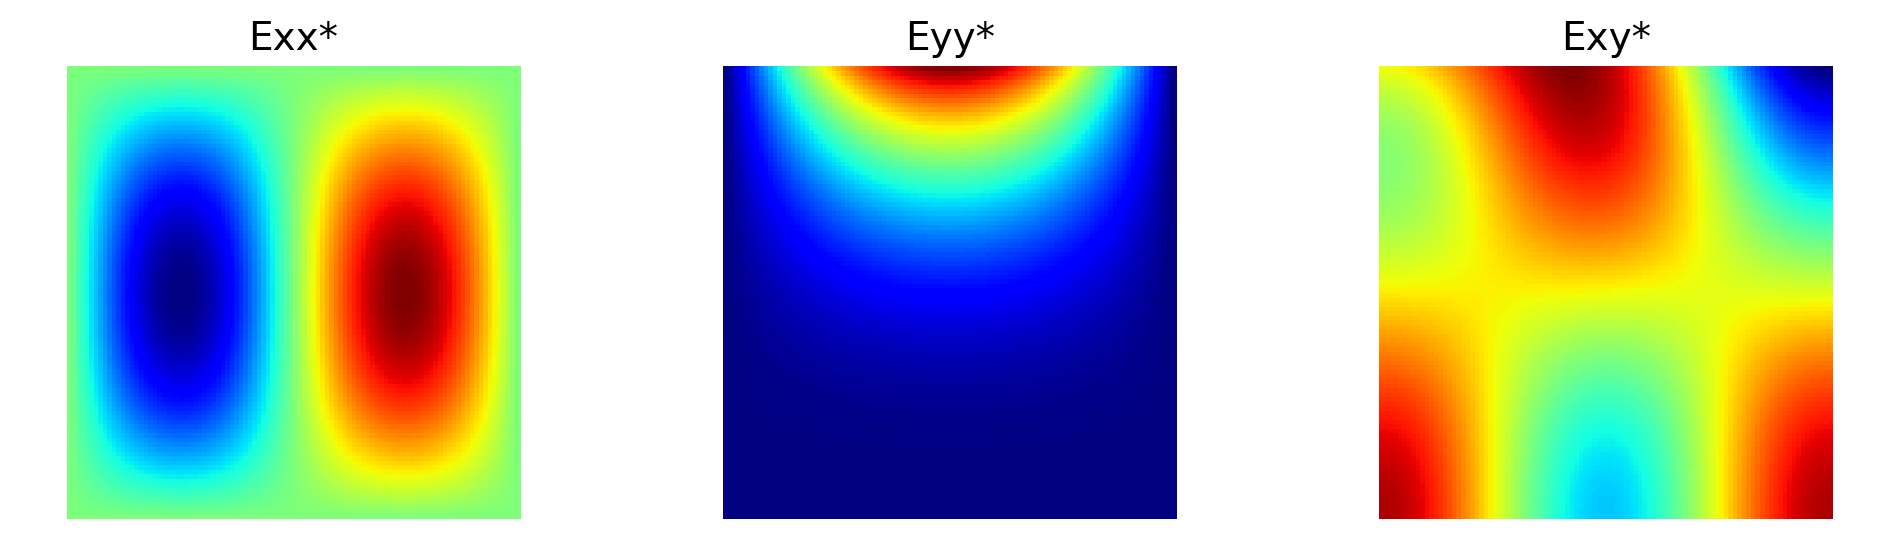

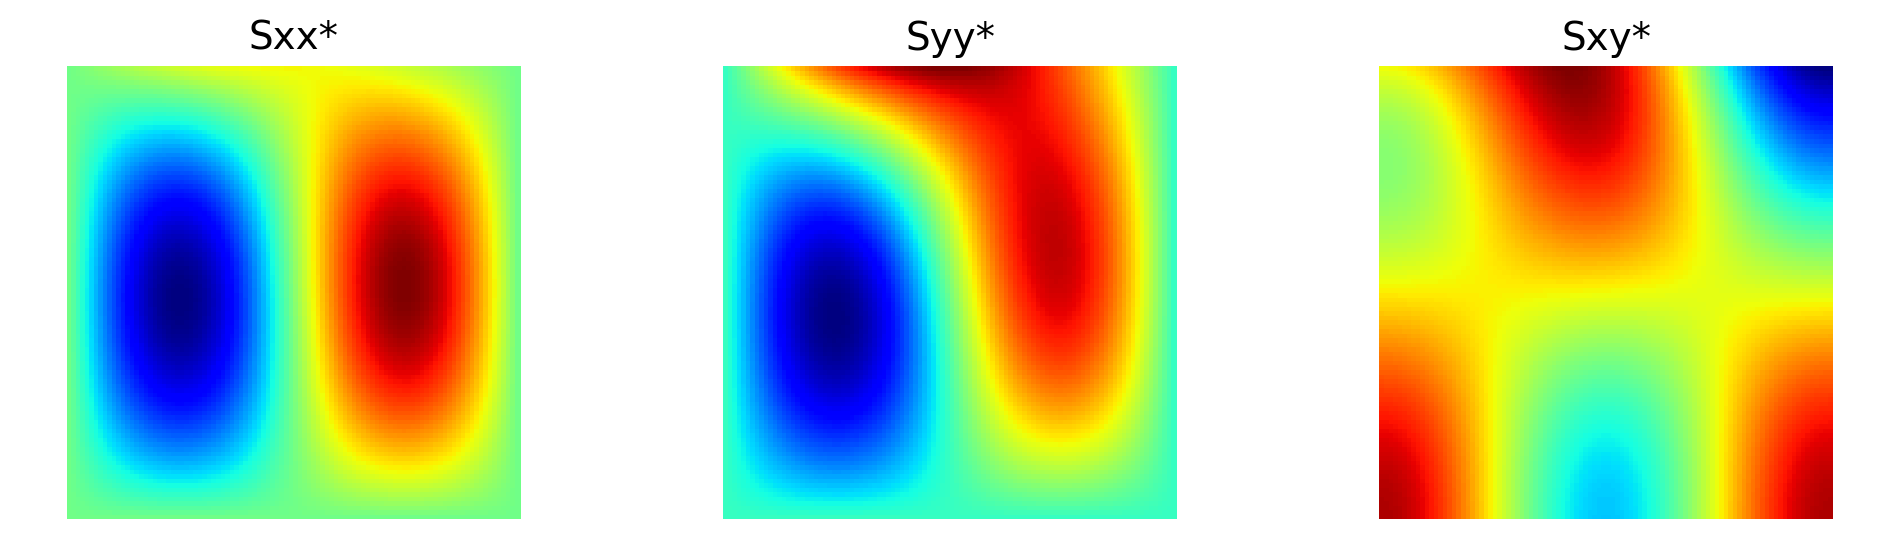

In [34]:
# plotting utilities
import matplotlib.pyplot as plt

def pcolor_plot(AX, X, Y, C, title,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap="jet")
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap="jet", vmin=cmin, vmax=cmax)
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

#plotting the analytical solution
lmbd = 1.0
mu = 0.5
Q = 4.0

XMIN, XMAX = 0.0, 1.0
YMIN, YMAX = 0.0, 1.0
domain = np.array([[XMIN, XMAX], [YMIN, YMAX]])

Xrange = np.linspace(XMIN, XMAX, 100).reshape((-1, 1))
Yrange = np.linspace(YMIN, YMAX, 100).reshape((-1, 1))

Xplot, Yplot = np.meshgrid(Xrange, Yrange)

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
pcolor_plot(ax[0], Xplot, Yplot, U_gt(Xplot, Yplot)[0], "Ux*")
pcolor_plot(ax[1], Xplot, Yplot, U_gt(Xplot, Yplot)[1], "Uy*")
pcolor_plot(ax[2], Xplot, Yplot, E_potential_gt(Xplot, Yplot), "E_potential*")

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
pcolor_plot(ax[0], Xplot, Yplot, E_gt(Xplot, Yplot)[0], "Exx*")
pcolor_plot(ax[1], Xplot, Yplot, E_gt(Xplot, Yplot)[1], "Eyy*")
pcolor_plot(ax[2], Xplot, Yplot, E_gt(Xplot, Yplot)[2], "Exy*")

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=200)
pcolor_plot(ax[0], Xplot, Yplot, S_gt(Xplot, Yplot)[0], "Sxx*")
pcolor_plot(ax[1], Xplot, Yplot, S_gt(Xplot, Yplot)[1], "Syy*")
pcolor_plot(ax[2], Xplot, Yplot, S_gt(Xplot, Yplot)[2], "Sxy*")

### PINN to solve the problem

In [153]:
import DIC_PINN as dpinn
import torch

# import importlib
# importlib.reload(dpinn)

# Define the loss function

def grad(Y,X):
    #calculate the gradient of u with respect to x
    return torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=True)[0]

def grad_i(Y,X,i):
    #calculate the partial derivative of y with respect to x_i
    return grad(Y,X)[:, None, i].flatten()

def E_nn(U,X):
    #calculate the strain given the displacement
    # u is the output of the NN, a tensor of shape (N,2)
    Exx = grad_i(U[:,0],X,0)
    Eyy = grad_i(U[:,1],X,1)
    Exy = 0.5 * (grad_i(U[:,1],X,0) +grad_i(U[:,0],X,1))
    return Exx, Eyy, Exy

def S_nn(E):
    #calculate the stress given the strain (tensor)
    Sxx = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy = 2 * mu * E[2]
    return Sxx, Syy, Sxy

def bodyf_nn(X):
    #body force for torch tensor
    x, y =  X[:,0], X[:,1]
    fx = lmbd*(4*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y)-torch.pi*torch.cos(torch.pi*x)*Q*y**3) \
        + mu*(9*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y) - torch.pi*torch.cos(torch.pi*x)*Q*y**3)
    fy = lmbd*(-3*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y)) \
        + mu*(-6*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y) + (torch.pi**2*torch.sin(torch.pi*x)*Q*y**4)/4)    
    return (fx, fy)

# Define Momentum balance and potential energy to be used as loss function

def E_potential_nn(NNu):
    # return a function of the potential energy associated with the network
    # the ouptut function take the spatial coordinate tensor as input
    strain = lambda x: E_nn(NNu(x),x)
    stress = lambda x: S_nn(strain(x))

    strain_energy = lambda x: (0.5 * (stress(x)[0]*strain(x)[0] + stress(x)[1]*strain(x)[1] + 2*stress(x)[2]*strain(x)[2])).flatten()
    bodyf_work = lambda x: (NNu(x)[:,0] * bodyf_nn(x)[0] + NNu(x)[:,1] * bodyf_nn(x)[1])
    E_pot = lambda x: strain_energy(x) - bodyf_work(x)
    return E_pot  

def PDE_nn(NNu):
    # return a function of the PDE norm (should be 0 to comply physics) associated with the network
    # the ouptut function take the spatial coordinate tensor as input
    stress = lambda x: S_nn(E_nn(NNu(x),x))
    PDE = lambda x: torch.abs(grad_i(stress(x)[0],x,0) + grad_i(stress(x)[2],x,1) + bodyf_nn(x)[0]) #+ torch.abs(grad_i(stress(x)[2],x,0) + grad_i(stress(x)[1],x,1) + bodyf_nn(x)[1])
    return PDE

def select_loss(NNu,loss_type):
    #calculate the PDE loss associated with the NN displacement
    #loss_type = "PDE norm" or "Energy norm"
    if loss_type == "PDE":
        PDE_loss = lambda x: PDE_nn(NNu)(x).mean()
        return PDE_loss
    elif loss_type == "Energy":
        E_pot_tot = lambda x: E_potential_nn(NNu)(x).mean()
        return E_pot_tot
    else:
        raise ValueError("loss_type must be 'PDE' or 'Energy'")

# plotting utility function
def plot_comparaison(Xplot,Yplot,NN,V_gt,n_fields=1,plot_diff=False):
    #plot the NN value and the ground truth compared to each other
    
    fields_name = V_gt.__name__.replace('_gt','')
    coord = ["_x","_y","_xy"] if n_fields > 1 else [""]

    X_input = np.hstack((Xplot.reshape(-1,1), Yplot.reshape(-1,1)))
    X_torch = torch.from_numpy(X_input).float()
    X_torch.requires_grad = True

    V_torch = NN(X_torch)
    
    if type(V_torch) is torch.Tensor and n_fields > 1:
        V_torch = [V_torch[:,i] for i in range(NN(X_torch).shape[1])]

    V_nn = []

    for i in range(n_fields):
        if n_fields == 1:
            V_nn.append(V_torch.reshape(Xplot.shape).detach().numpy())
        else:
            V_nn.append(V_torch[i].reshape(Xplot.shape).detach().numpy())

    for i in range(n_fields):
        fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)

        cmax = max(V_nn[i].max(), V_gt(Xplot, Yplot)[i].max())
        cmin = min(V_nn[i].min(), V_gt(Xplot, Yplot)[i].min())

        im1 = pcolor_plot(ax[0], Xplot, Yplot, V_gt(Xplot, Yplot)[i], f"{fields_name}{coord[i]}*", cmin=cmin, cmax=cmax)
        im2 = pcolor_plot(ax[1], Xplot, Yplot, V_nn[i], f"{fields_name}{coord[i]}_nn", cmin=cmin, cmax=cmax)

        fig.colorbar(im1, ax=ax)

        if plot_diff:
            fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
            im3 = pcolor_plot(ax, Xplot, Yplot, V_nn[i] - V_gt(Xplot, Yplot)[i], f"{fields_name}{coord[i]}_diff")
            fig.colorbar(im3, ax=ax)

PDE loss for the ground truth:  tensor(2.6303e-06, grad_fn=<MeanBackward0>)
Energy loss for the ground truth:  tensor(-7.9058, grad_fn=<MeanBackward0>)


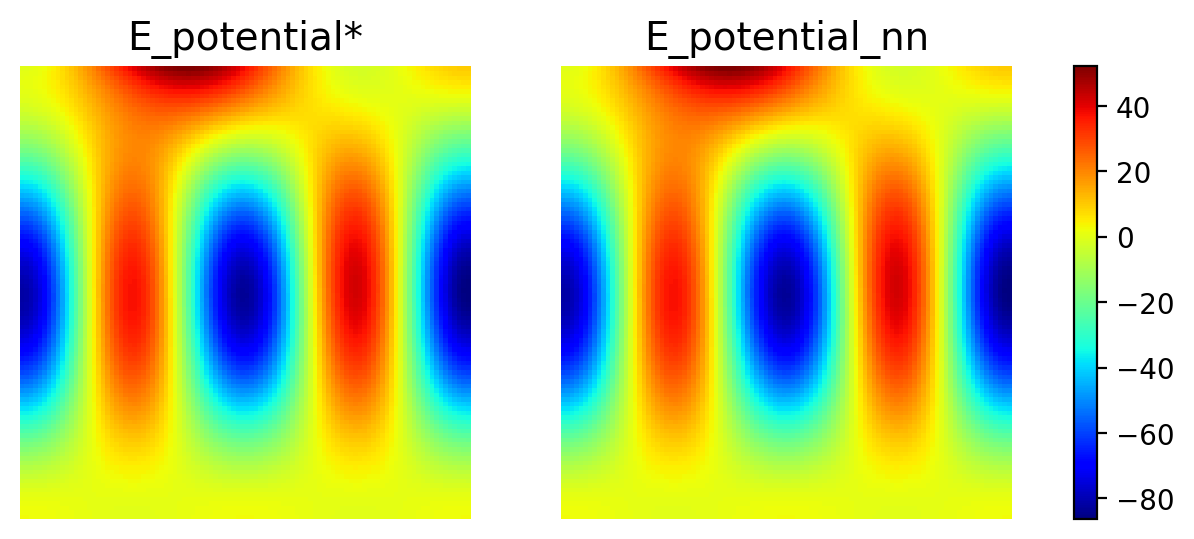

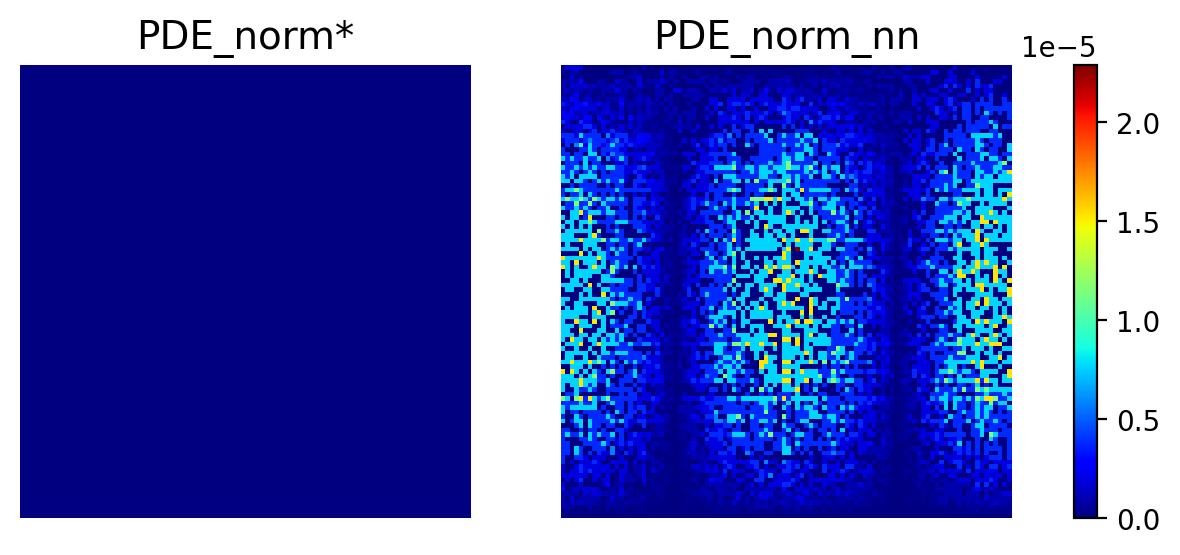

In [154]:
# Sanity check of the loss functions defined above

def U_gt_nn(x):
    # ground truth displacement as a torch tensor
    ux = torch.cos(2*torch.pi*x[:,0]) * torch.sin(torch.pi*x[:,1])
    uy = torch.sin(torch.pi*x[:,0]) * Q * x[:,1]**4/4
    return torch.hstack((ux.reshape(-1,1),uy.reshape(-1,1)))

# --> displacement, strain, stress should be equal to the ground truth
# --> PDE loss should close to 0, energy loss should close to -7.766 J

E_gt_nn = lambda x: E_nn(U_gt_nn(x),x)
S_gt_nn = lambda x: S_nn(E_gt_nn(x))

def PDE_norm_gt(x,y):
    return [np.zeros((len(x),len(y)))]
PDE_norm_gt_nn = lambda x: PDE_nn(U_gt_nn)(x)

E_potential_gt_nn = lambda x: E_potential_nn(U_gt_nn)(x)

# domain definition
XMIN, XMAX = 0.0, 1.0
YMIN, YMAX = 0.0, 1.0

Xmesh = np.linspace(XMIN, XMAX, 100).reshape((-1, 1))
Ymesh = np.linspace(YMIN, YMAX, 100).reshape((-1, 1))
Xplot, Yplot = np.meshgrid(Xmesh, Ymesh)
X_input = np.hstack((Xplot.reshape(-1,1), Yplot.reshape(-1,1)))
X_torch = torch.from_numpy(X_input).float()
X_torch.requires_grad = True

#printing the loss values
PDE_loss_gt_nn = select_loss(U_gt_nn,"PDE")
Energy_loss_gt_nn = select_loss(U_gt_nn,"Energy")

print('PDE loss for the ground truth: ', PDE_loss_gt_nn(X_torch))
print('Energy loss for the ground truth: ', Energy_loss_gt_nn(X_torch))

# plotting the displacement, strain, stress compared to the ground truth

# plot_comparaison(Xplot, Yplot,U_gt_nn,U_gt,n_fields=2)
# plot_comparaison(Xplot, Yplot,E_gt_nn,E_gt,n_fields=3)
# plot_comparaison(Xplot, Yplot,S_gt_nn,S_gt,n_fields=3)

# plotting the displacement, strain, stress compared to the ground truth

plot_comparaison(Xplot, Yplot,E_potential_gt_nn,E_potential_gt,n_fields=1)
plot_comparaison(Xplot, Yplot,PDE_norm_gt_nn,PDE_norm_gt,n_fields=1)

PDE loss before training :  tensor(4.2062, grad_fn=<MeanBackward0>)


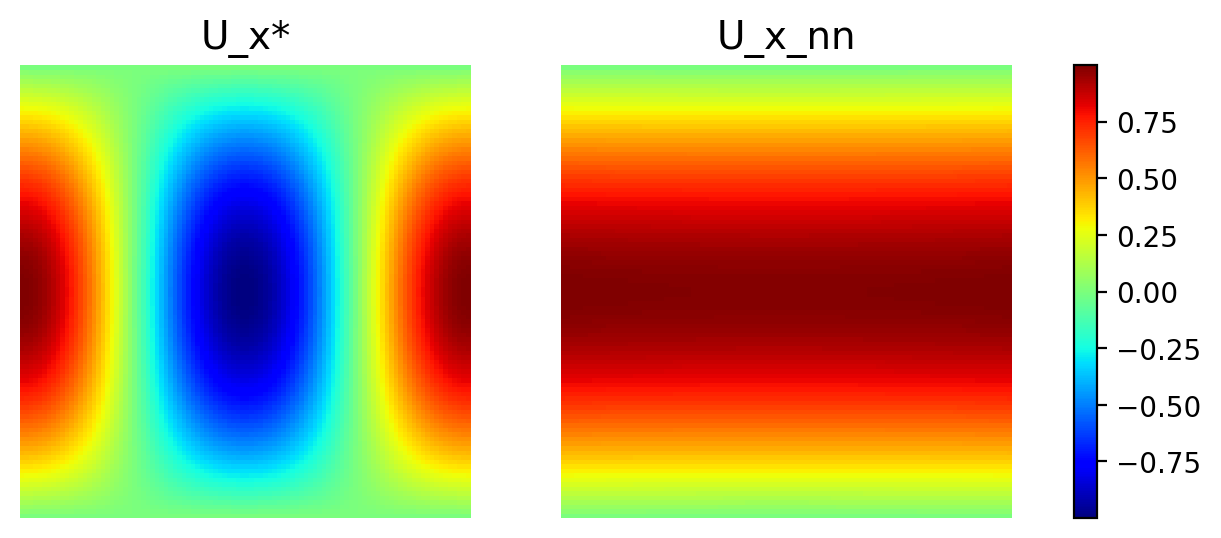

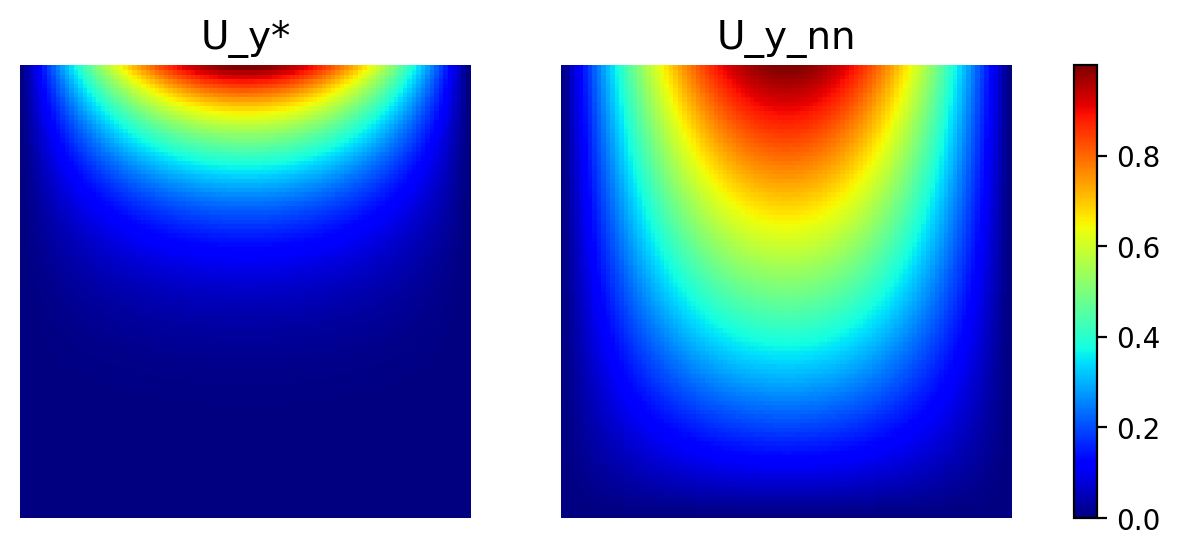

In [175]:
## Defining the neural network

# NN parameters
layers = [2, 20, 20, 20, 20, 2]
loss_type = ["Energy", "PDE"][0]
activation = ["Tanh","ReLU","Sigmoid"][0]

# BCs hardly enforced
Weight_func = lambda X,Y: X * (1 - X) * Y * (1 - Y)

BCx_solution = lambda X,Y: torch.sin(torch.tensor(torch.pi)*Y)
BCy_solution = lambda X,Y: Y*torch.sin(torch.tensor(torch.pi)*X)

def Enforce_BC(x,u):
    Ux = u[:,0]*Weight_func(x[:,0],x[:,1]) + BCx_solution(x[:,0],x[:,1])
    Uy = u[:,0]*Weight_func(x[:,0],x[:,1]) + BCy_solution(x[:,0],x[:,1])
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

# NN definition
NNu = dpinn.FF_PINN(layers, activation,Enforce_BC)

PDE_loss = select_loss(NNu,loss_type)

# sanity check that the BCs are respected

print('PDE loss before training : ', PDE_loss(X_torch))
plot_comparaison(Xplot, Yplot,NNu,U_gt,n_fields=2)

In [176]:
# Training the neural network
num_epochs = 1000

optimizer = torch.optim.Adam(NNu.parameters(), lr=1e-3)
scheduler = dpinn.lr_scheduler(optimizer,"constant", num_epochs)
PDE_sampling = dpinn.domain_sampling(domain,"uniform",50)

NNu.train(num_epochs,optimizer,scheduler, PDE_sampling, PDE_loss)

Epoch: 0, Loss: 3.788e+00
Epoch: 100, Loss: -4.674e-01
Epoch: 200, Loss: -1.537e+00
Epoch: 300, Loss: -1.907e+00
Epoch: 400, Loss: -2.007e+00
Epoch: 500, Loss: -2.027e+00
Epoch: 600, Loss: -2.029e+00
Epoch: 700, Loss: -2.030e+00
Epoch: 800, Loss: -2.030e+00
Epoch: 900, Loss: -2.030e+00


PDE loss : -2.9501147270202637 (ground truth = -7.905777454376221 )


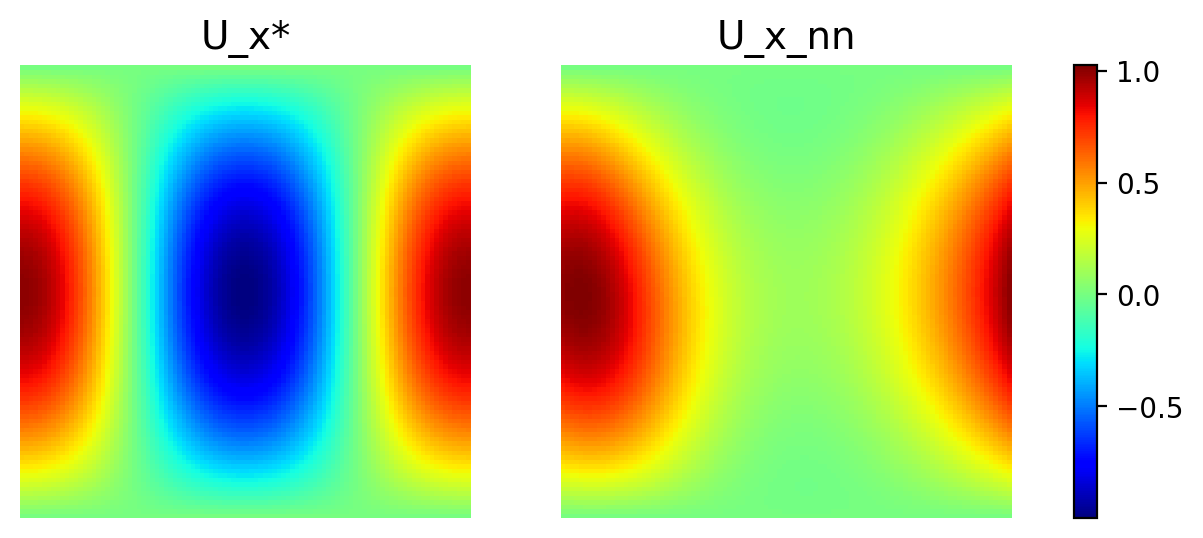

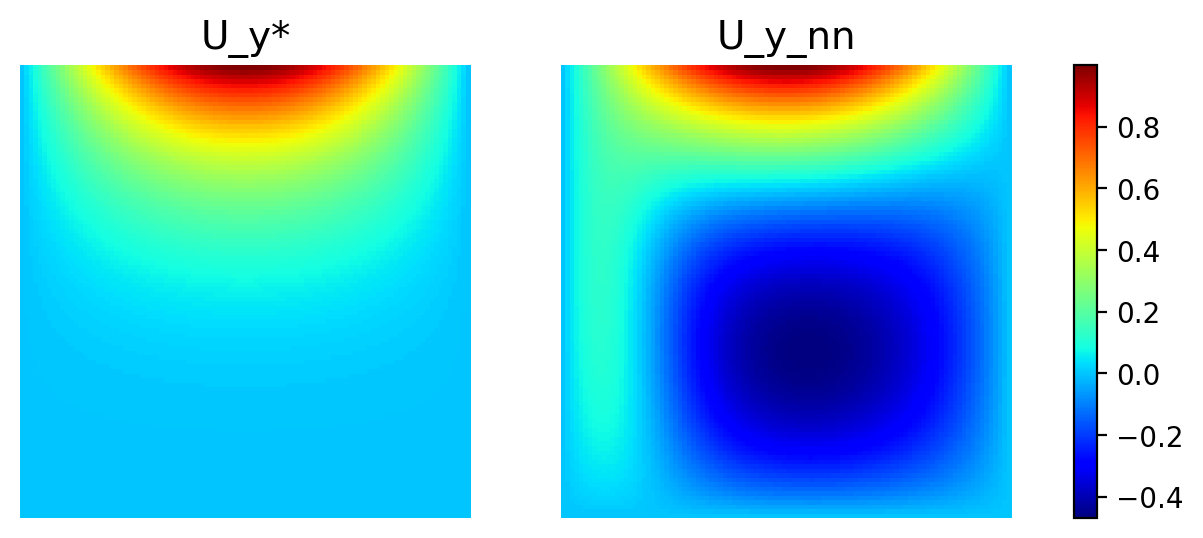

In [178]:
print(f'PDE loss : {PDE_loss(X_torch)} (ground truth = {select_loss(U_gt_nn,loss_type)(X_torch)} )')
plot_comparaison(Xplot, Yplot,NNu,U_gt,n_fields=2,plot_diff=False)